## **Hengameh Khajehpour 301122261**
## **Peyman Moshfegh     301151808**
## **COMP257  SEC002**
## **Final Project**

In [ ]:
from google.colab import files
from os import path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [ ]:
# Import file into colab path

if path.exists('umist_cropped.mat'):
  pass
else:
  uploaded = files.upload()

Saving umist_cropped.mat to umist_cropped.mat


## **Define and show the data**

In [ ]:
# Retrieve and load the UMist Faces dataset

'''
Grayscale faces 8 bit [0-255]
Different views of 20 different people
575 total images 112x92 size
manually cropped by Daniel Graham at UMist
'''

mat_contents = loadmat('umist_cropped.mat')
data = mat_contents['facedat'][0]
dirNames = mat_contents['dirnames'][0]

print(f'Keys in our Matlab file: {mat_contents.keys()}\n')
print(f"File includes images of {data.shape[0]} Different Persons\n")
print(f"Every Image is {data[0][:,:,0].shape} Pixels, With Type of {type(data[0])}\n")
print(f"First Person has {data[0].shape[2]} different images\n")
print(f"Fifth Person has {data[4].shape[2]} different images\n")
print(f"Target Shape is {dirNames.shape}")

Keys in our Matlab file: dict_keys(['__header__', '__version__', '__globals__', 'facedat', 'dirnames'])

File includes images of 20 Different Persons

Every Image is (112, 92) Pixels, With Type of <class 'numpy.ndarray'>

First Person has 38 different images

Fifth Person has 26 different images

Target Shape is (20,)


In [ ]:
label = 0
faces = []
target = []
string_target = []

for i in range(len(data)):
    for _ in range(data[i].shape[2]):
        faces.append(data[i][:, :, _])
        target.append(label)
        string_target.append(dirNames[i][0])
    label += 1

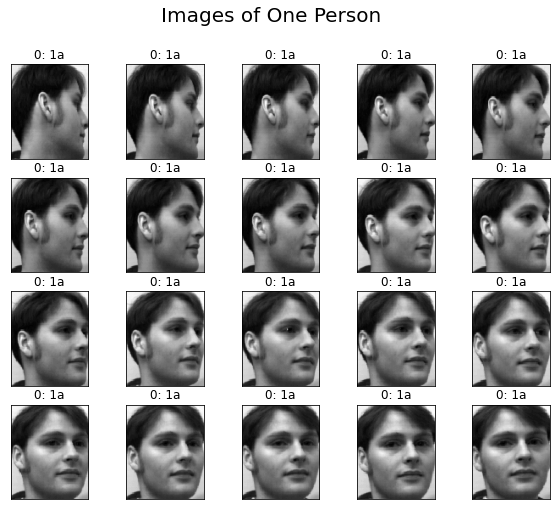

In [ ]:
fig, axs=plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
fig.suptitle('Images of One Person', fontsize=20) 
axs=axs.flatten()
i = 5

for I in range(20):
  pid = data[i][:,:,I];
  axs[I].imshow(pid, cmap='gray');
  axs[I].set_title(f"{target[i]}: {string_target[i]}");
  axs[I].set_xticks([]);
  axs[I].set_yticks([]);

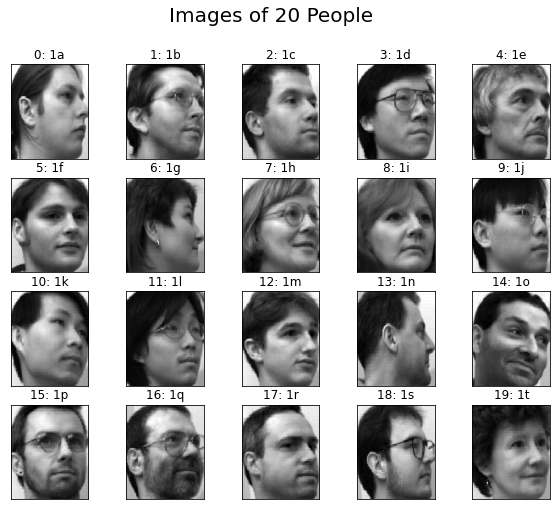

In [ ]:
fig, axs=plt.subplots(nrows = 4, ncols = 5, figsize = (10, 8))
fig.suptitle('Images of 20 People', fontsize = 20) 
axs = axs.flatten()

for p in range(20):
  axs[p].imshow(data[p][:,:,15], cmap='gray');
  axs[p].set_title(f"{p}: {sorted(list(set(string_target)))[p]}");
  axs[p].set_xticks([]);
  axs[p].set_yticks([]);

Number of all images: 575
Every image pixels: 10304
Image labels: 
	['1a', '1b', '1c', '1d', '1e', '1f', '1g', '1h', '1i', '1j', '1k', '1l', '1m', '1n', '1o', '1p', '1q', '1r', '1s', '1t']
Person 1 with label "1b" has the image:
	 [234 233 234 ... 125 125 125]


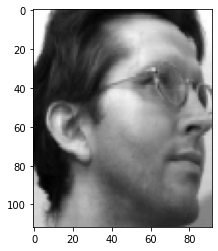

In [ ]:
faces = np.array(faces)
faces = faces.reshape(faces.shape[0], -1)
target = np.array(target)
string_target = np.array(string_target)

print(f"Number of all images: {faces.shape[0]}")
print(f"Every image pixels: {faces.shape[1]}") # 112x92
print(f"Image labels: \n\t{list(np.unique(string_target))}")
print(f'Person {target[50]} with label "{string_target[50]}" has the image:')
plt.imshow(faces[50].reshape(112, 92), cmap="gray")
print('\t',faces[50])

## **Split Our Data**

In [ ]:
# Split dataset into the training, validation, and test set
# returns stratified randomized folds (preserving the percentage of samples for each class)

X, y = faces, target

data_srs = StratifiedShuffleSplit(n_splits =5, test_size=0.1)

for train_valid_index, test_index in data_srs.split(X, y):
    X_train_valid, X_test = X[train_valid_index], X[test_index]
    y_train_valid, y_test = y[train_valid_index], y[test_index]

data_srs_2 = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

for train_index, valid_index in data_srs_2.split(X_train_valid, y_train_valid):
    X_train, X_valid = X_train_valid[train_index], X_train_valid[valid_index]
    y_train, y_valid = y_train_valid[train_index], y_train_valid[valid_index]
    
print('Train Shape \t', X_train.shape, y_train.shape)
print('Test Shape \t', X_test.shape, y_test.shape)
print('Valid Shape \t', X_valid.shape, y_valid.shape)

Train Shape 	 (413, 10304) (413,)
Test Shape 	 (58, 10304) (58,)
Valid Shape 	 (104, 10304) (104,)


## **Reduce Dimensionality**

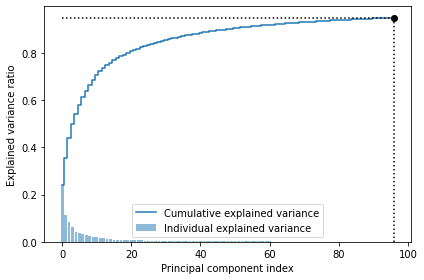



Number of components to keep 0.95% of variance is 96.


In [ ]:
# Reduce the size of data (dimensionality)

pca=PCA(0.95)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

components = pca.n_components_


# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.plot([0, components], [0.95, 0.95], "k:")
plt.plot([components, components], [0, 0.95], "k:")
plt.plot(components, 0.95, "ko")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print(f'\n\nNumber of components to keep {sum(pca.explained_variance_ratio_):.2f}% of variance is {components}.')

## **Use K-Measn Clustering**

In [ ]:
# Use K-Means for Clustering

silhouette_avg = []
kmeans_per_k = []
num_clusters_k = range(5,150, 5)

for k in num_clusters_k:
  print(f'\rCluster {k}', end='')
  kmeans = KMeans(n_clusters = k)
  kmeans.fit(X_train_pca)
  kmeans_per_k.append(kmeans)
  labels_kmean = kmeans.labels_
  silhouette_avg.append(silhouette_score(X_train_pca, labels_kmean))

best_index_k = np.argmax(silhouette_avg)
best_k = num_clusters_k[best_index_k]
best_score_k = silhouette_avg[best_index_k]
best_model_k = kmeans_per_k[best_index_k]

print(f'\rbest cluster number:\t {best_k}')
print(f'best index of cluster:\t{best_index_k}')
print(f'best silhouette score:\t {best_score_k:.2f}')
print(f'best kmean model:\t {best_model_k}')

best cluster number:	 110
best index of cluster:	21
best silhouette score:	 0.37
best kmean model:	 KMeans(n_clusters=110)


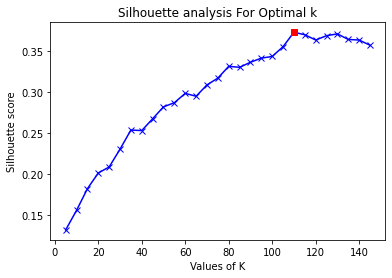

In [ ]:
plt.plot(num_clusters_k, silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.plot(best_k, best_score_k, "rs")
plt.show()

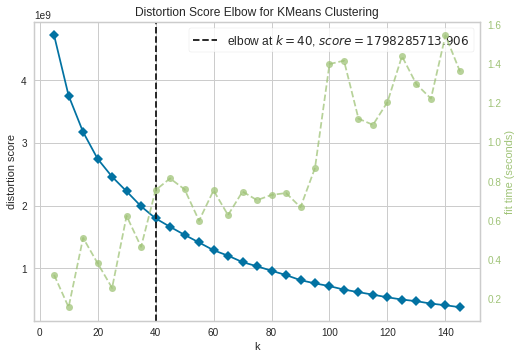

In [ ]:
# Elbow Method for K means
from yellowbrick.cluster import KElbowVisualizer

X_train_pca2 = X_train_pca.copy()
model = KMeans(random_state =10)
visualizer = KElbowVisualizer(model, k=num_clusters_k, timings= True)
visualizer.fit(X_train_pca2)
visualizer.show()

Cluster 1


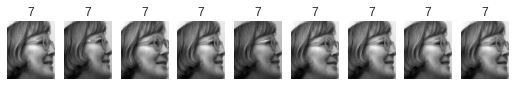

Cluster 3


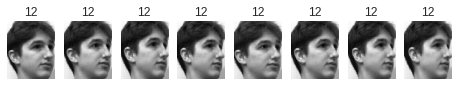

Cluster 4


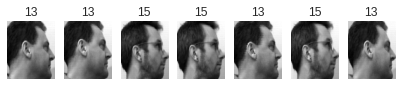

Cluster 7


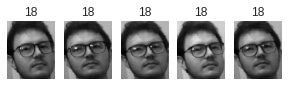

Cluster 9


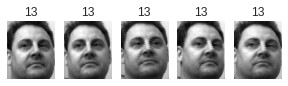

Cluster 11


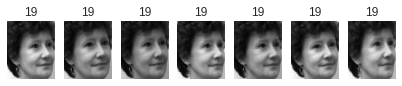

Cluster 14


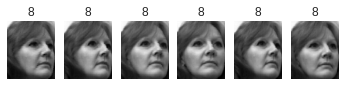

Cluster 15


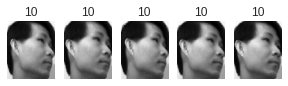

Cluster 16


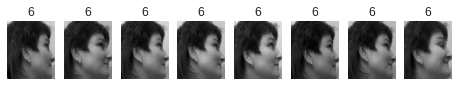

Cluster 17


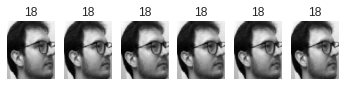

Cluster 18


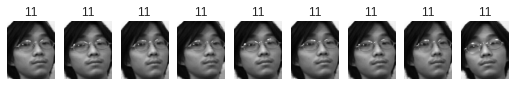

Cluster 19


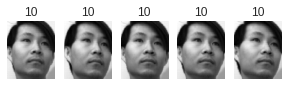

Cluster 22


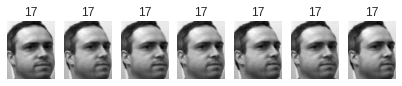

Cluster 23


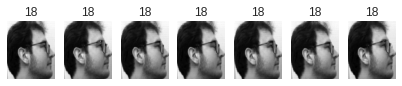

Cluster 26


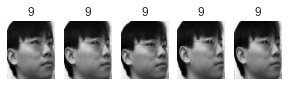

Cluster 28


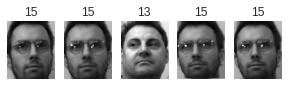

Cluster 29


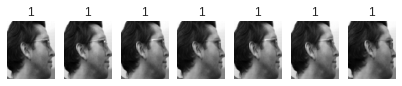

Cluster 31


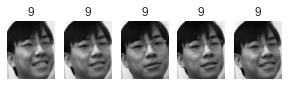

Cluster 38


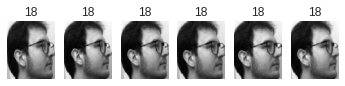

Cluster 39


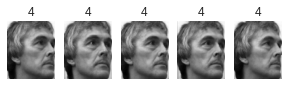

Cluster 43


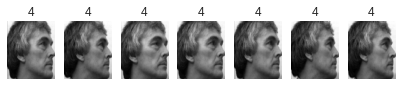

Cluster 46


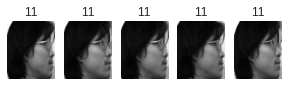

Cluster 47


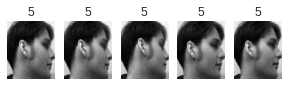

Cluster 49


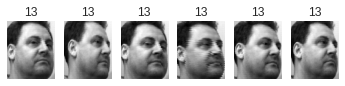

Cluster 53


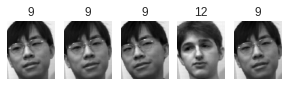

Cluster 66


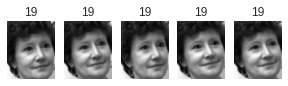

Cluster 68


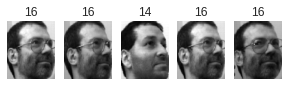

Cluster 70


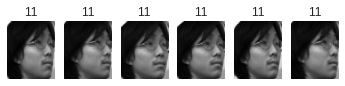

Cluster 74


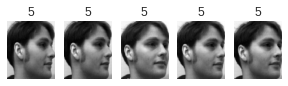

Cluster 79


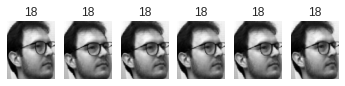

Cluster 92


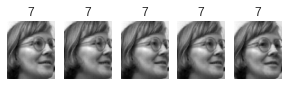

Cluster 93


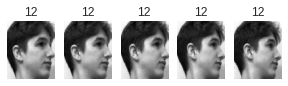

In [ ]:
# Visualize the clusters

def plot_faces(faces, labels, n_cols=10): 
    faces = faces.reshape(-1, 112, 92)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

dict_images = {}

for cluster_id in np.unique(best_model_k.labels_):
  in_cluster = best_model_k.labels_ == cluster_id
  faces_kmeans = X_train[in_cluster]
  labels_faces_k = y_train[in_cluster]

  dict_images[cluster_id] = labels_faces_k

  if len(faces_kmeans) >= 5:
    print("Cluster", cluster_id)
    plot_faces(faces_kmeans, labels_faces_k)

In [ ]:
dict_images

{0: array([1, 1]),
 1: array([7, 7, 7, 7, 7, 7, 7, 7, 7]),
 2: array([10, 10, 10]),
 3: array([12, 12, 12, 12, 12, 12, 12, 12]),
 4: array([13, 13, 15, 15, 13, 15, 13]),
 5: array([0, 0, 0, 0]),
 6: array([17, 17, 17, 17]),
 7: array([18, 18, 18, 18, 18]),
 8: array([5, 5, 5, 5]),
 9: array([13, 13, 13, 13, 13]),
 10: array([19, 19, 19, 19]),
 11: array([19, 19, 19, 19, 19, 19, 19]),
 12: array([3, 3, 3, 3]),
 13: array([1, 1]),
 14: array([8, 8, 8, 8, 8, 8]),
 15: array([10, 10, 10, 10, 10]),
 16: array([6, 6, 6, 6, 6, 6, 6, 6]),
 17: array([18, 18, 18, 18, 18, 18]),
 18: array([11, 11, 11, 11, 11, 11, 11, 11, 11]),
 19: array([10, 10, 10, 10, 10]),
 20: array([0, 0]),
 21: array([1, 1]),
 22: array([17, 17, 17, 17, 17, 17, 17]),
 23: array([18, 18, 18, 18, 18, 18, 18]),
 24: array([0]),
 25: array([1, 1]),
 26: array([9, 9, 9, 9, 9]),
 27: array([10, 10, 10, 10]),
 28: array([15, 15, 13, 15, 15]),
 29: array([1, 1, 1, 1, 1, 1, 1]),
 30: array([15, 15, 15, 15]),
 31: array([9, 9, 9, 9

In [ ]:
y_pred_valid_kmean = best_model_k.predict(X_valid_pca)
y_pred_valid_kmean

array([  0,   1,  56,  62,  88,  54,  64,  95,   3,  90,  75,  62,  43,
        43,  82,  98, 105,  54,  99,  93,  71,  43,  18,  65, 103,  98,
        29,  85, 105,  17,  41,  76,  99,  84,  51,  66,  46,  54,  50,
       100,  36,  34,  53,  95,  36, 102,  53,  30, 103,  34,  23,  70,
        45,  39,  68,   7,  50,  41,  85,  54,  56,  69,  23,  89,  15,
        40,  65,  10,  60,  55,  46,  76,  99, 109,  56,  71,  79,  15,
       101,  68,  74, 105,  45,  91,  71,  62,  94,  44,  57,  44,  92,
        86,  66,  11,  69,  52,  21,  72,  16,   7,  10,  31, 100,  85],
      dtype=int32)

In [ ]:
# Compare labels manually

pred_labels_kmeans = []

for i in y_pred_valid_kmean:
  pred_labels_kmeans.append(np.bincount(dict_images[i]).argmax())

print(pred_labels_kmeans,'\n')
y_valid

[1, 7, 0, 16, 2, 7, 14, 17, 12, 3, 17, 16, 4, 4, 19, 5, 13, 7, 17, 12, 18, 4, 11, 6, 8, 5, 1, 9, 13, 18, 10, 15, 17, 15, 4, 19, 11, 7, 1, 0, 9, 13, 9, 17, 9, 1, 9, 15, 8, 13, 18, 11, 11, 4, 16, 18, 1, 10, 9, 7, 0, 12, 18, 16, 10, 2, 6, 19, 3, 0, 11, 15, 17, 2, 0, 18, 18, 10, 19, 16, 5, 13, 11, 3, 18, 16, 15, 2, 16, 2, 7, 10, 19, 19, 12, 0, 1, 10, 6, 18, 19, 9, 0, 9] 



array([ 1,  7,  0, 14,  2,  7, 14, 17, 12,  3, 17, 16,  4,  4,  5,  5, 13,
        8, 17, 12, 18,  4, 11,  6,  8,  5,  1,  9, 13, 18, 10, 15, 17, 15,
        4, 19, 11,  7,  1,  0,  9, 13,  3, 17,  9,  1, 12, 15,  8, 13, 18,
       11, 11,  4, 16, 18,  1, 10,  9,  8,  0, 12, 18, 16, 10,  2,  6, 19,
        3,  0, 11, 15, 17,  2,  0, 18, 18, 10, 19, 16,  5, 13, 11,  3, 18,
       14, 15,  2, 16,  2,  7, 10, 19, 19, 12,  0,  1, 10,  6, 18, 19,  9,
        0,  9])

In [ ]:
acc = sum([y_valid[i] == pred_labels_kmeans[i] for i in range(len(y_valid))]) / len(y_valid)

print(f"Accuracy of the kmeans clustering for the validation set is {100 * acc:.2f}%.")

Accuracy of the kmeans clustering for the validation set is 93.27%.


In [ ]:
# Use Classification without Clustering

clf = LogisticRegression(solver='liblinear');
clf.fit(X_train_pca, y_train);

print(f'Accuracy Without Clustering : {(clf.score(X_valid_pca, y_valid)*100):.2f}%');
print('*'*35,end='\n\n')

Accuracy Without Clustering : 90.38%
***********************************



/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
# Use clustering as preprocessing for classification

y_labels_cluster_k = []

pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=best_k)),
    ('Logistic Regression', LogisticRegression(solver='liblinear'))
])

pipeline.fit(X_train_pca, y_train)
y_pred_cluster = pipeline.predict(X_valid_pca)
y_labels_cluster_k.append(y_pred_cluster)
ac_sc = metrics.accuracy_score(y_valid, y_pred_cluster)

print(f'Accuracy Validation With K-Measn Clustering: {((ac_sc)*100):.2f}%')
print('*'*35,end='\n\n')
print(f'Predict labels:\n{y_labels_cluster_k}\n')
print(f'Origin labels:\n{y_valid}')

Accuracy Validation With K-Measn Clustering: 99.04%
***********************************

Predict labels:
[array([ 1,  7,  0, 14,  2,  7, 14, 17, 12,  3, 17, 16,  4,  4,  5,  5, 13,
        8, 17, 12, 18,  4, 11,  6,  8,  5,  1,  9, 13, 18, 10, 15, 17, 15,
        4, 19, 11,  7,  1,  0,  9, 13, 10, 17,  9,  1, 12, 15,  8, 13, 18,
       11, 11,  4, 16, 18,  1, 10,  9,  8,  0, 12, 18, 16, 10,  2,  6, 19,
        3,  0, 11, 15, 17,  2,  0, 18, 18, 10, 19, 16,  5, 13, 11,  3, 18,
       14, 15,  2, 16,  2,  7, 10, 19, 19, 12,  0,  1, 10,  6, 18, 19,  9,
        0,  9])]

Origin labels:
[ 1  7  0 14  2  7 14 17 12  3 17 16  4  4  5  5 13  8 17 12 18  4 11  6
  8  5  1  9 13 18 10 15 17 15  4 19 11  7  1  0  9 13  3 17  9  1 12 15
  8 13 18 11 11  4 16 18  1 10  9  8  0 12 18 16 10  2  6 19  3  0 11 15
 17  2  0 18 18 10 19 16  5 13 11  3 18 14 15  2 16  2  7 10 19 19 12  0
  1 10  6 18 19  9  0  9]


## **Neural Network prediction for Kmeans algorithm**

In [ ]:
print(X_train_pca.shape)
y_train_pca = best_model_k.predict(X_train_pca)
print(y_train_pca.shape)

(413, 96)
(413,)


In [ ]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train_pca = lb.fit_transform(y_train_pca)              # fit_transform = find all unique class labels + transform into one-hot encoded labels
y_pred_valid_kmean = lb.transform(y_pred_valid_kmean)    # transform = perform the one-hot encoding (unique class labels already found)
print(y_train_pca.shape)
print(y_pred_valid_kmean.shape)

(413, 110)
(104, 110)


In [ ]:
y_test_pca = best_model_k.predict(X_test_pca)
y_pred_test_kmean = lb.transform(y_test_pca)

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(256, input_shape=(96,), activation="relu"))
model.add(Dense(256, activation="sigmoid"))
model.add(Dense(256, activation="relu"))
model.add(Dense(110, activation="softmax"))

model.summary()

model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_82 (Dense)            (None, 256)               24832     
                                                                 
 dense_83 (Dense)            (None, 256)               65792     
                                                                 
 dense_84 (Dense)            (None, 256)               65792     
                                                                 
 dense_85 (Dense)            (None, 110)               28270     
                                                                 
Total params: 184,686
Trainable params: 184,686
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train_pca, y_train_pca, validation_data=(X_valid_pca, y_pred_valid_kmean), epochs=20, batch_size=64)

Epoch 1/20
7/7 [==============================] - 1s 49ms/step - loss: 4.5463 - accuracy: 0.0823 - val_loss: 4.0051 - val_accuracy: 0.1154
Epoch 2/20
7/7 [==============================] - 0s 12ms/step - loss: 3.6685 - accuracy: 0.3075 - val_loss: 3.4713 - val_accuracy: 0.3077
Epoch 3/20
7/7 [==============================] - 0s 14ms/step - loss: 3.0296 - accuracy: 0.4818 - val_loss: 2.9662 - val_accuracy: 0.4327
Epoch 4/20
7/7 [==============================] - 0s 15ms/step - loss: 2.4272 - accuracy: 0.6320 - val_loss: 2.5928 - val_accuracy: 0.4808
Epoch 5/20
7/7 [==============================] - 0s 16ms/step - loss: 1.9279 - accuracy: 0.7240 - val_loss: 2.2250 - val_accuracy: 0.5000
Epoch 6/20
7/7 [==============================] - 0s 11ms/step - loss: 1.5189 - accuracy: 0.7966 - val_loss: 1.8821 - val_accuracy: 0.5288
Epoch 7/20
7/7 [==============================] - 0s 10ms/step - loss: 1.1832 - accuracy: 0.8402 - val_loss: 1.6034 - val_accuracy: 0.6154
Epoch 8/20
7/7 [===========

In [ ]:
model.evaluate(X_test_pca, y_pred_test_kmean)

2/2 [==============================] - 0s 8ms/step - loss: 0.4625 - accuracy: 0.8793


[0.4625399708747864, 0.8793103694915771]

## **Use Gaussian Mixture**

In [ ]:
all_aic = []
all_bic = []

f_aic = []
f_bic = []
t_aic = []
t_bic = []
s_aic = []
s_bic = []
d_aic = []
d_bic = []

min_bic = np.infty
min_aic = np.infty

for k in range(1, 20):
    print(f'\rComponent {k}', end='')
    for covariance_type in ["full", "tied", "spherical", "diag"]: 
        models = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X_train_pca)
        
        aic = models.aic(X_train_pca)
        bic = models.bic(X_train_pca)

        all_aic.append(aic);
        if aic < min_aic:
            min_aic = aic
            best_k_a = k
            best_covariance_type_a = covariance_type
        all_bic.append(bic);
        if bic < min_bic:
            min_bic = bic
            best_k_b = k
            best_covariance_type_b = covariance_type
        if(covariance_type=="full"):
          f_aic.append(aic)
          f_bic.append(bic)
        if(covariance_type=="tied"):
          t_aic.append(aic)
          t_bic.append(bic)
        if(covariance_type=="spherical"):
          s_aic.append(aic)
          s_bic.append(bic)
        if(covariance_type=="diag"):
          d_aic.append(aic)
          d_bic.append(bic)

Component 19

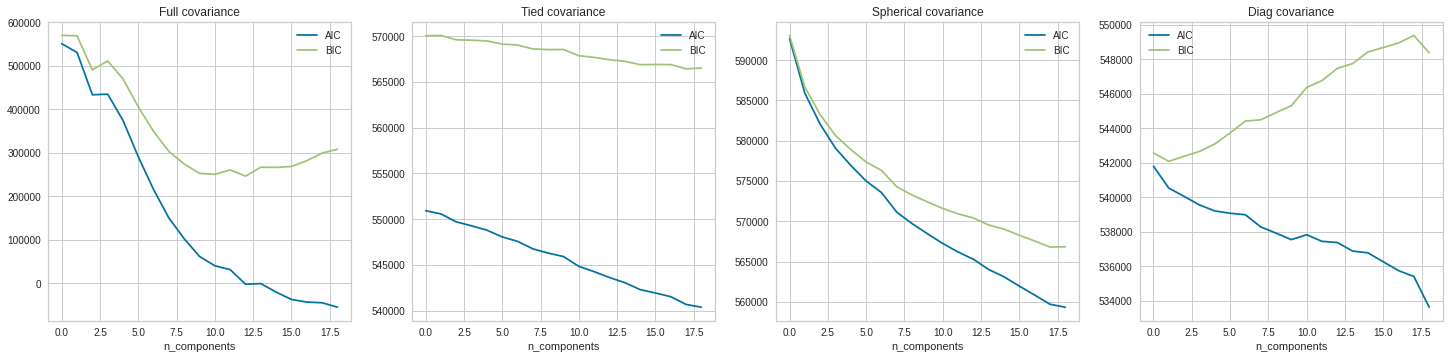

In [ ]:
fig, (axs1,axs2,axs3,axs4) = plt.subplots(1, 4)
fig.set_figwidth(25)
# fig.tight_layout(pad=1.0)
axs1.plot(f_aic, label='AIC')
axs1.plot(f_bic, label='BIC')
axs1.set_title('Full covariance')
axs2.plot(t_aic, label='AIC')
axs2.plot(t_bic, label='BIC')
axs2.set_title('Tied covariance')
axs3.plot(s_aic, label='AIC')
axs3.plot(s_bic, label='BIC')
axs3.set_title('Spherical covariance')
axs4.plot(d_aic, label='AIC')
axs4.plot(d_bic, label='BIC')
axs4.set_title('Diag covariance')

for ax in [axs1,axs2,axs3,axs4]:
    ax.set(xlabel='n_components')
    ax.legend(loc='best');

In [ ]:
print(f'The Akaike information criterion (AIC) measures: \t{aic:.2f}\n')
print(f'Best Covariance is "{best_covariance_type_a}" with {best_k_a} Cluster Numbers')

The Akaike information criterion (AIC) measures: 	533636.17

Best Covariance is "full" with 19 Cluster Numbers


In [ ]:
print(f'The Bayesian information criterion (BIC) measures: \t{bic:.2f}\n')
print(f'Best Covariance is "{best_covariance_type_b}" with {best_k_b} Cluster Numbers')

The Bayesian information criterion (BIC) measures: 	548386.13

Best Covariance is "full" with 13 Cluster Numbers


In [ ]:
gm_model = GaussianMixture(n_components=best_k_a, covariance_type=best_covariance_type_a).fit(X_train_pca)
g_train_lables = gm_model.predict(X_train_pca)
print('hard clustering')
g_valid_labels = gm_model.predict(X_valid_pca)
print(g_valid_labels)
print('soft clustering')
probs = gm_model.predict_proba(X_valid_pca)
print(probs.round(2))

hard clustering
[ 7  3 15  6 15  9  8  6  2 17  1  6  3 17  8  9 13  9  4  2  4 17 18  9
  3  9 15  2  6 17  2  6  4  9  8 12 10  9 14 15 15  9  0 13 15 14  0  8
  3  9 17 12 18  3  4  1 14  2  2  9 15  0 17  6 16  7  9 12 17  5 10 13
  4 11 15  4  4 16 10  4  2 13 18 16  1  6  8 15 13 15  3 16 12 12  0  7
 11  8 10  1 12  0 14  2]
soft clustering
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


Text(0.5, 1.0, 'Valid Set')

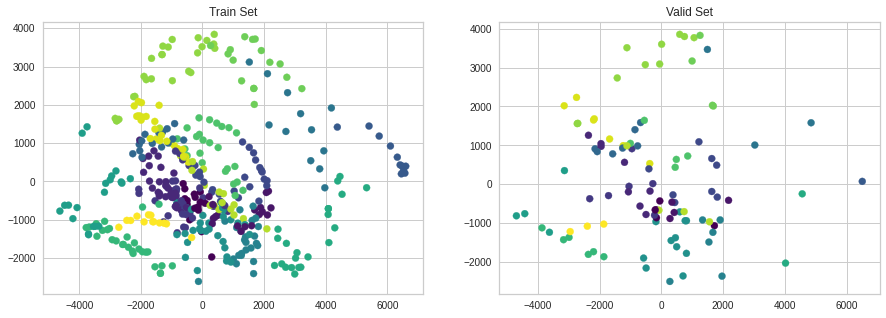

In [ ]:
fig, (axs1,axs2) = plt.subplots(1, 2, figsize=(15, 5))
axs1.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=g_train_lables, cmap='viridis');
axs1.set_title('Train Set')

axs2.scatter(X_valid_pca[:, 0], X_valid_pca[:, 1], c=g_valid_labels, cmap='viridis');
axs2.set_title('Valid Set')

In [ ]:
print(X_train_pca.shape)
data_new = gm_model.sample(2)[0]
data_new.shape

(413, 96)


(2, 96)

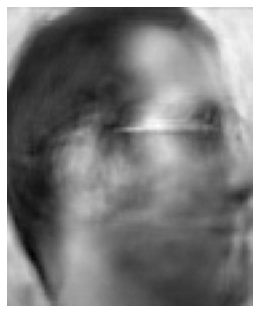

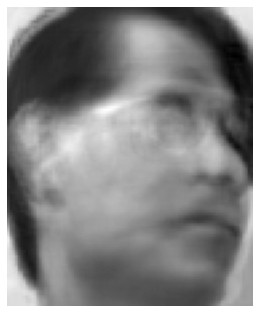

In [ ]:
face_recovered = pca.inverse_transform(data_new)
origin = face_recovered.reshape(2, 112, 92)
plt.axis('off')
plt.imshow(origin[0], cmap='gray')
plt.show()
plt.axis('off')
plt.imshow(origin[1], cmap='gray')
plt.show()

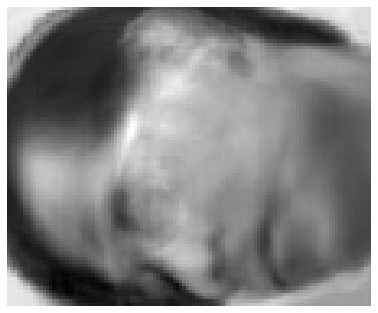

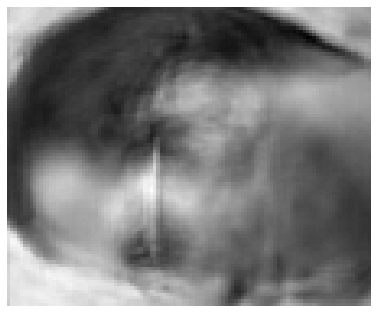

In [ ]:
rotate = np.array([origin[::-1][0].T, origin[::-1][1].T])
plt.axis('off')
plt.imshow(rotate[0], cmap='gray')
plt.show()
plt.axis('off')
plt.imshow(rotate[1], cmap='gray')
plt.show()

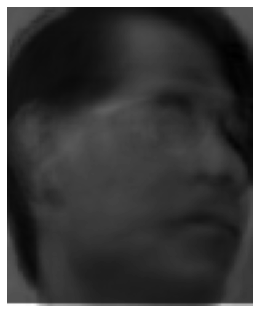

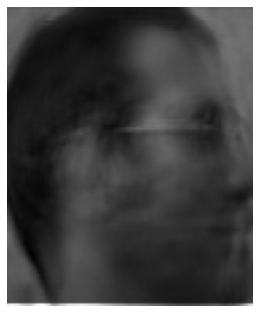

In [ ]:
dark = np.array([origin[::-1][0], origin[::-1][1]])
dark[:, 0:-1] *= 0.3
plt.axis('off')
plt.imshow(dark[0], cmap='gray')
plt.show()
plt.axis('off')
plt.imshow(dark[1], cmap='gray')
plt.show()

In [ ]:
origin = pca.transform(origin.reshape(2, 10304))
rotate = pca.transform(rotate.reshape(2, 10304))
print(f'score of origin \t{gm_model.score_samples(origin)}')
print(f'score of rotation \t{gm_model.score_samples(rotate)}')

score of origin 	[351.74107008 299.57670894]
score of rotation 	[-1.53484032e+12 -1.75977506e+12]


In [ ]:
dark = pca.transform(dark.reshape(2, 10304))
print(f'score of origin \t{gm_model.score_samples(origin)}')
print(f'score of darkness \t{gm_model.score_samples(dark)}')

score of origin 	[351.74107008 299.57670894]
score of darkness 	[-5.20879598e+12 -5.68423006e+12]


## **Prediction Test**

In [ ]:
# Predict With Kmeasn

y_labels_test_k = []

y_pred_test_k = pipeline.predict(X_test_pca)
y_labels_test_k.append(y_pred_test_k)

ac_sc_k = metrics.accuracy_score(y_test, y_pred_test_k)

print(f'Accuracy Test With K-Measn Clustering: {((ac_sc_k)*100):.2f}%')
print('*'*35,end='\n\n')
print(f'Predict labels:\n{y_labels_test_k}\n')
print(f'Origin labels:\n{y_test}')

Accuracy Test With K-Measn Clustering: 100.00%
***********************************

Predict labels:
[array([16,  4,  2, 13,  8, 16,  0, 14,  9,  5, 17,  1, 12, 18,  1, 17,  7,
       19,  0, 18, 11,  2,  7,  9, 18,  4,  0, 18,  6,  6, 17, 14, 12,  1,
        3, 15, 11, 10, 12, 15, 13, 11, 19,  8,  9,  4,  0, 15,  3, 19,  1,
       10,  5, 13,  2, 18, 10, 16])]

Origin labels:
[16  4  2 13  8 16  0 14  9  5 17  1 12 18  1 17  7 19  0 18 11  2  7  9
 18  4  0 18  6  6 17 14 12  1  3 15 11 10 12 15 13 11 19  8  9  4  0 15
  3 19  1 10  5 13  2 18 10 16]


In [ ]:
# Predict With Gaussian Mixture

print('hard clustering')
g_test_labels = gm_model.predict(X_test_pca)
print(g_test_labels)
print('soft clustering')
probs_test = gm_model.predict_proba(X_test_pca)
print(probs_test[:10].round(2))

hard clustering
[ 1  9 15 13  3  6  5  6  0  2  1  7  2 17 11  1  3 12 14 17 10  7  3  2
 17  3  7  1 12  9  1 13  0  7 16  8 12 16  2  8  6 18 12  9  2 17 15  8
 16 10 15 11  9  9 15 17 11  1]
soft clustering
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Text(0.5, 1.0, 'Test Set')

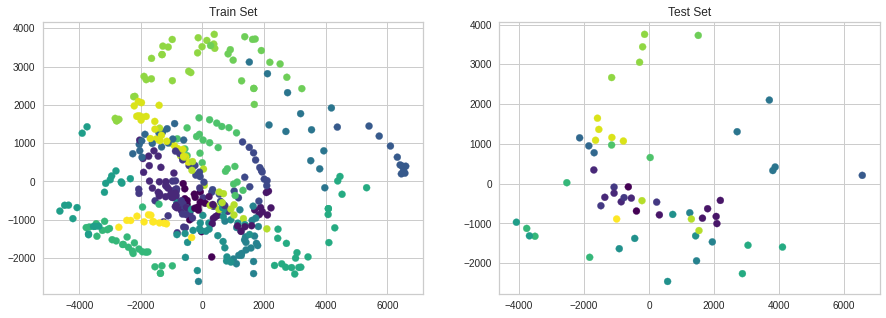

In [ ]:
fig, (axs1,axs2) = plt.subplots(1, 2, figsize=(15, 5))
axs1.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=g_train_lables, cmap='viridis');
axs1.set_title('Train Set')

axs2.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=g_test_labels, cmap='viridis');
axs2.set_title('Test Set')

## **Neural Network prediction for GMM algorithm**

In [ ]:
y_train_gmm = gm_model.predict(X_train_pca)
y_valid_gmm = gm_model.predict(X_valid_pca)
y_test_gmm = gm_model.predict(X_test_pca)

y_train_gmm = lb.fit_transform(y_train_gmm)
y_valid_gmm = lb.transform(y_valid_gmm)
y_test_gmm = lb.transform(y_test_gmm)

print(y_train_gmm.shape)

(413, 19)


In [ ]:
model = Sequential()
model.add(Dense(256, input_shape=(96,), activation="relu"))
model.add(Dense(256, activation="sigmoid"))
model.add(Dense(256, activation="relu"))
model.add(Dense(19, activation="softmax"))

model.summary()

model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_86 (Dense)            (None, 256)               24832     
                                                                 
 dense_87 (Dense)            (None, 256)               65792     
                                                                 
 dense_88 (Dense)            (None, 256)               65792     
                                                                 
 dense_89 (Dense)            (None, 19)                4883      
                                                                 
Total params: 161,299
Trainable params: 161,299
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train_pca, y_train_gmm, validation_data=(X_valid_pca, y_valid_gmm), epochs=20, batch_size=64)

Epoch 1/20
7/7 [==============================] - 1s 47ms/step - loss: 2.4933 - accuracy: 0.2857 - val_loss: 1.7410 - val_accuracy: 0.5962
Epoch 2/20
7/7 [==============================] - 0s 12ms/step - loss: 1.3223 - accuracy: 0.8087 - val_loss: 1.1165 - val_accuracy: 0.7596
Epoch 3/20
7/7 [==============================] - 0s 12ms/step - loss: 0.8119 - accuracy: 0.8862 - val_loss: 0.7768 - val_accuracy: 0.8558
Epoch 4/20
7/7 [==============================] - 0s 16ms/step - loss: 0.4909 - accuracy: 0.9395 - val_loss: 0.5506 - val_accuracy: 0.8558
Epoch 5/20
7/7 [==============================] - 0s 14ms/step - loss: 0.3289 - accuracy: 0.9685 - val_loss: 0.4240 - val_accuracy: 0.9038
Epoch 6/20
7/7 [==============================] - 0s 15ms/step - loss: 0.2177 - accuracy: 0.9879 - val_loss: 0.4092 - val_accuracy: 0.9135
Epoch 7/20
7/7 [==============================] - 0s 13ms/step - loss: 0.1609 - accuracy: 0.9855 - val_loss: 0.3081 - val_accuracy: 0.9038
Epoch 8/20
7/7 [===========

In [ ]:
model.evaluate(X_test_pca, y_test_gmm)

2/2 [==============================] - 0s 6ms/step - loss: 0.3586 - accuracy: 0.8621


[0.35855263471603394, 0.8620689511299133]